# PROJET 6 : Classifiez automatiquement des biens de consommation

# SOMMAIRE
## [CONTEXTE DU PROJET](#1)<a class="anchor" id="sommaire"></a>
## [LES DONNEES DU PROJET](#2)<a class="anchor" id="sommaire"></a>
## [IMPORT DES LIBRAIRIES](#3)<a class="anchor" id="sommaire"></a>
## [CHARGEMENT DES DONNEES](#4)<a class="anchor" id="sommaire"></a>
## [1. ANALYSE INDIVIDUELLE DES DATASETS](#5)<a class="anchor" id="sommaire"></a>
## [2. FUSION ET NETTOYAGE DES DONNEES](#6)<a class="anchor" id="sommaire"></a>
## [3. CLUSTERING METHODE RFM](#7)<a class="anchor" id="sommaire"></a>
## [4. SEGMENTATION CLIENTS AUGMENTEE](#8)<a class="anchor" id="sommaire"></a>
## [5. TEST STABILITE MODELE DANS LE TEMPS](#9)<a class="anchor" id="sommaire"></a>

## [CONTEXTE DU PROJET](#sommaire)<a class="anchor" id="1"></a>

<p>Vous êtes Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce.

Sur la place de marché, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible et dans l'optique d'un passage à l'échelle, il devient nécessaire d'automatiser cette tâche.

Linda, lead data scientist, vous demande donc d'étudier la faisabilité d'un moteur de classification des articles en différentes catégories, avec un niveau de précision suffisant.</p>

## [LES DONNEES DU PROJET](#sommaire)<a class="anchor" id="2"></a>

Linda vous a fourni un premier jeu de données d’articles avec le lien pour télécharger la photo et une description associée.

## [IMPORT DES LIBRAIRIES](#sommaire)<a class="anchor" id="3"></a>

In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
import string
import time

from wordcloud import WordCloud
import nltk
from nltk.stem import WordNetLemmatizer
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, ne_chunk

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix, silhouette_score, homogeneity_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.manifold import TSNE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import gensim

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mathieu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


def split_text(x):
    x = x.split('>>')
    x = x[0]
    x = x[2:-1]
    return x

def normalize_text_1(x):
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    x = tokenizer.tokenize(x.lower())
    return x

def del_num(x):
    if type(x) is list:
        x = list(map(str, x))
        x.sort()
        x = [i for i in x if not i.isnumeric()]
    elif type(x) is dict:
        y = x.keys.sort()
        for i in x.keys():
            if i.isnumeric():
                del x[i]
    print(x)
    return x

def cluster(transform): 

    cluster_nmf = []

    for i in X1.argsort():
        cluster_nmf.append(i[-1])
    
    return cluster_nmf
    
def print_plot(index):
    example = tempo[tempo.index == index][['description', 'cat_level1']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])
        

## [CHARGEMENT DES DONNEES](#sommaire)<a class="anchor" id="4"></a>

In [3]:
raw_data = pd.read_csv('Data/raw.csv')

## [PARTIE TEXTE](#sommaire)<a class="anchor" id="4"></a>

In [4]:
raw_data

uniq_id            crawl_timestamp  \
0     55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1     7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2     64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3     d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4     6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   
...                                ...                        ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

                                            product_url  \
0     http://www.flipkart.com/elegance-polyester-mul...   
1     http://www.flipkart.com/sathiyas-cotton-bath-t...   
2     http://www.flipkart.com/eurospa-cotton-terry-f...   
3     http://www.flipkart.com/santosh-royal-fashion-...   
4     http://www.flipkart.com/jaipur-print-cotton-fl...   
...                                                 ...   
1045  http://www.flipkart.com/oren-empower-extra-lar...   
1046  http://www.flipkart.com/wallmantra-large-vinyl...   
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree               pid  \
0     ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   
...                                                 ...               ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE88ZGTX65GH4V   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZD5GDCVQ   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE5UVGW2JWVWCT   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZGFD3RCE   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE2ZEPACRQJKH7   

      retail_price  discounted_price                                 image  \
0           1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1            600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2              NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3           2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4           2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   
...            ...               ...                                   ...   
1045        1399.0             999.0  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046        4930.0            1896.0  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047        4500.0            1449.0  5912e037d12774bb73a2048f35a00009.jpg   
1048        3465.0            1333.0  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

Notre partie ne va s'intéresser qu'aux colonnes : "uniq_id", "product_category_tree", "description". Et ces parties n'ont aucune donnée non null. 

In [6]:
mask = raw_data.retail_price.isna()
raw_data[mask]

uniq_id            crawl_timestamp  \
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   

                                         product_url  \
2  http://www.flipkart.com/eurospa-cotton-terry-f...   

                          product_name  \
2  Eurospa Cotton Terry Face Towel Set   

                               product_category_tree               pid  \
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   

   retail_price  discounted_price                                 image  \
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   

   is_FK_Advantage_product                                        description  \
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   

        product_rating       overall_rating    brand  \
2  No rating available  No rating available  Eurospa   

                              product_specifications  
2  {"product_specification"=>[{"key"=>"Material",...

In [7]:
raw_data['cat_level1'] = raw_data.product_category_tree.apply(lambda x: split_text(x))

Nous procédons à l'extraction de la catégorie niveau 1 de chaque produits afin de tester par la suite la réussite de la classification non supervisée.

In [8]:
b = raw_data.loc[:, ['cat_level1','description']]
b.cat_level1.value_counts()

Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: cat_level1, dtype: int64

On remarque ici que chaque produit est parfaitement réparti dans les 7 catégories.

In [9]:
raw_data.describe(include = 'all')

uniq_id            crawl_timestamp  \
count                               1050                       1050   
unique                              1050                        149   
top     55b85ea15a1536d46b7190ad6fff8ce7  2015-12-01 12:40:44 +0000   
freq                                   1                        150   
mean                                 NaN                        NaN   
std                                  NaN                        NaN   
min                                  NaN                        NaN   
25%                                  NaN                        NaN   
50%                                  NaN                        NaN   
75%                                  NaN                        NaN   
max                                  NaN                        NaN   

                                              product_url  \
count                                                1050   
unique                                               1050   
top     http://www.flipkart.com/elegance-polyester-mul...   
freq                                                    1   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                             product_name  \
count                                                1050   
unique                                               1050   
top     Elegance Polyester Multicolor Abstract Eyelet ...   
freq                                                    1   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                    product_category_tree               pid  \
count                                                1050              1050   
unique                                                642              1050   
top     ["Home Furnishing >> Bed Linen >> Blankets, Qu...  CRNEG7BKMFFYHQ8Z   
freq                                                   56                 1   
mean                                                  NaN               NaN   
std                                                   NaN               NaN   
min                                                   NaN               NaN   
25%                                                   NaN               NaN   
50%                                                   NaN               NaN   
75%                                                   NaN               NaN   
max                                                   NaN               NaN   

         retail_price  discounted_price                                 image  \
count     1049.000000       1049.000000                                  1050   
unique            NaN               NaN                                  1050   
top               NaN               NaN  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
freq              NaN               NaN                                     1   
mean      2186.197331       1584.527169                                   NaN   
std       7639.229411       7475.099680                                   NaN   
min         35.000000         35.000000                                   NaN   
25%        555.000000        340.000000                                   NaN   
50%        999.000000        600.000

In [10]:
transform = OrdinalEncoder()
raw_data['cat_level1_encode'] = transform.fit_transform(raw_data['cat_level1'].to_numpy().reshape(-1, 1))

On prévoit une colonne des catégorie en version numérique pour les comparaison dans les matrices de confusion.

In [11]:
tempo = raw_data.loc[:, ['description', 'cat_level1']].copy()

Prenons des exemples des textes de description disponibles pour avoir une première idée du nettoyage qu'il faudra effectuer.

In [12]:
print_plot(10)

Calibro SW-125 Analog-Digital Watch  - For Men, Boys
                         Price: Rs. 699
				
			CALIBRO presents MTG Black Dial Round Watch. This is a fashionable watch from MTG that adds to your style statement. This brand is known for its usage of quality material in making appealing watches. It understands the needs of youth so well that it is able to present wide range of watches to its customers. The variety in design, style and youthful approach is very well executed by this brand. Get one and see how brilliantly it leads other brands in style, finish and everything else that matters.
CALIBRO presents MTG Black Dial Round Watch. This is a fashionable watch from MTG that adds to your style statement. This brand is known for its usage of quality material in making appealing watches. It understands the needs of youth so well that it is able to present wide range of watches to its customers. The variety in design, style and youthful approach is very well executed by this brand. 

In [13]:
print_plot(110)

Key Features of TWISHA Printed Kurti & Salwar Kurta Fabric: Cotton,TWISHA Printed Kurti & Salwar Price: Rs. 869 FLAMINGO AND POLKA PRINT KURTA WITH SALWAR-BLACK,Specifications of TWISHA Printed Kurti & Salwar Salwar Kurta Dupatta Details Sleeve Sleeveless Kurta Type Straight Type Kurti & Salwar Neck ROUND Salwar Fabric Cotton Kurta Fabric Cotton General Details Pattern Printed Occasion Festive Ideal For Baby Girl's Fabric Care Hand wash
Product: Baby Care


On ne remarque pas de grandes spéficités au niveau des mots ou ponctuations à nettoyer dans ces textes.

In [14]:
tempo

description       cat_level1
0     Key Features of Elegance Polyester Multicolor ...  Home Furnishing
1     Specifications of Sathiyas Cotton Bath Towel (...        Baby Care
2     Key Features of Eurospa Cotton Terry Face Towe...        Baby Care
3     Key Features of SANTOSH ROYAL FASHION Cotton P...  Home Furnishing
4     Key Features of Jaipur Print Cotton Floral Kin...  Home Furnishing
...                                                 ...              ...
1045  Oren Empower Extra Large Self Adhesive Sticker...        Baby Care
1046  Wallmantra Large Vinyl Sticker Sticker (Pack o...        Baby Care
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...        Baby Care
1048  Buy Wallmantra Medium Vinyl Sticker Sticker fo...        Baby Care
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...        Baby Care

[1050 rows x 2 columns]

In [15]:
tempo['Length'] = tempo['description'].apply(len)

In [16]:
tempo.groupby('Length').describe().head(20)

description                                                            \
             count unique                                                top   
Length                                                                         
109              2      2  Buy Nkp Cotton Bath Towel at Rs. 549 at Flipka...   
111              1      1  Specifications of OMRD RD6697 Hot and cold Pac...   
112              3      3  Next Steps Baby Girl's Layered Dress\r\n      ...   
113              1      1  Specifications of Milani Runway shadow Wet/Dry...   
114              3      3  Buy Neyth Cotton Set of Towels at Rs. 170 at F...   
115              1      1  Buy Mandhania Cotton Bath Towel at Rs. 280 at ...   
116              1      1  Buy BabyBucket Cotton Bath Towel at Rs. 735 at...   
117              3      3  Buy Rajrang Animal Cushions Cover at Rs. 984 a...   
118              2      2  Buy BornBabyKids Cotton Bath Towel at Rs. 589 ...   
119              2      2  Buy Love Baby Cartoon Set of Towels at Rs. 425...   
121              5      5  Buy Moonleaf Geometric Cushions Cover at Rs. 1...   
122              1      1  Buy Tuktuk Abstract Single Dohar Black at Rs. ...   
123              4      4  Buy Shrikant Traders Cotton Bath Towel at Rs. ...   
124              1      1  Buy Raymond Abstract Double Blanket Red at Rs....   
125              5      5  Buy Welhouse Cotton Hand & Face Towel Set at R...   
126              2      2  Buy Raymond Abstract Double Blanket Green at R...   
127              5      5  Buy Raymond Abstract Single Blanket Orange at ...   
128              5      5  Flipkart.com is offering MyKid Nappy for only ...   
129              2      2  Buy Ireeya Abstract Single Coral Blanket Blue ...   
130              1      1  Buy The Art Box Floral Single Dohar Multicolor...   

            cat_level1                                        
       freq      count unique                       top freq  
Length                                                        
109       1          2      1           Home Furnishing    2  
111       1          1      1  Beauty and Personal Care    1  
112       1          3      2                 Baby Care    2  
113       1          1      1  Beauty and Personal Care    1  
114       1          3      2           Home Furnishing    2  
115       1          1      1           Home Furnishing    1  
116       1          1      1                 Baby Care    1  
117       1          3      1           Home Furnishing    3  
118       1          2      2                 Baby Care    1  
119       1          2      2                 Baby Care    1  
121       1          5      1           Home Furnishing    5  
122       1          1      1           Home Furnishing    1  
123       1          4      2                 Baby Care    2  
124       1          1      1           Home Furnishing    1  
125       1          5      2           Home Furnishing    4  
126       1          2      1           Home Furnishing    2  
127       1          5      2           Home Furnishing    4  
128       1          5      2           Home Furnishing    4  
129       1          2      2                 Baby Care    1  
130       1          1      1           Home Furnishing    1

/home/mathieu/anaconda3/envs/myenv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


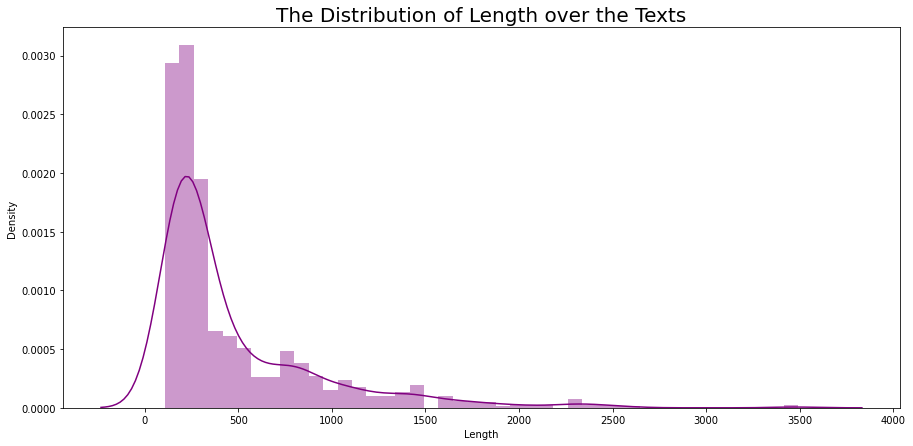

In [17]:
# looking at the distribution of length of the different texts

plt.rcParams['figure.figsize'] = (15, 7)
sns.distplot(tempo['Length'], color = 'purple')
plt.title('The Distribution of Length over the Texts', fontsize = 20)
plt.show()

On voit que les textes vont d'une 100ène de mots à plus de 3500 mots, la grande partie des descriptions est compris entre 100 et 500 mots. 

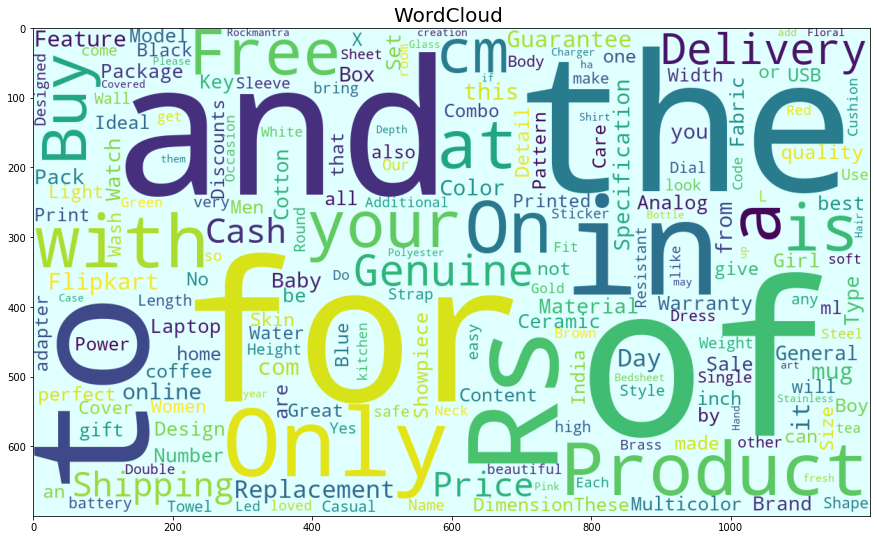

In [18]:
wordcloud = WordCloud(background_color = 'lightcyan',
                      width = 1200,
                      height = 700, collocations=False, stopwords='ignore'
                     ).generate(' '.join(tempo['description'].values))

plt.figure(figsize = (15, 10))
plt.imshow(wordcloud)
plt.title("WordCloud ", fontsize = 20)
plt.show()

On voit dans le wordcloud qu'il y a beaucoup de mots parasites : des mots de liaison comme 'of', des conjonctions comme 'and', des mots du champ lexicale de la vente qui doivent être éliminés : 'Buy', ...

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

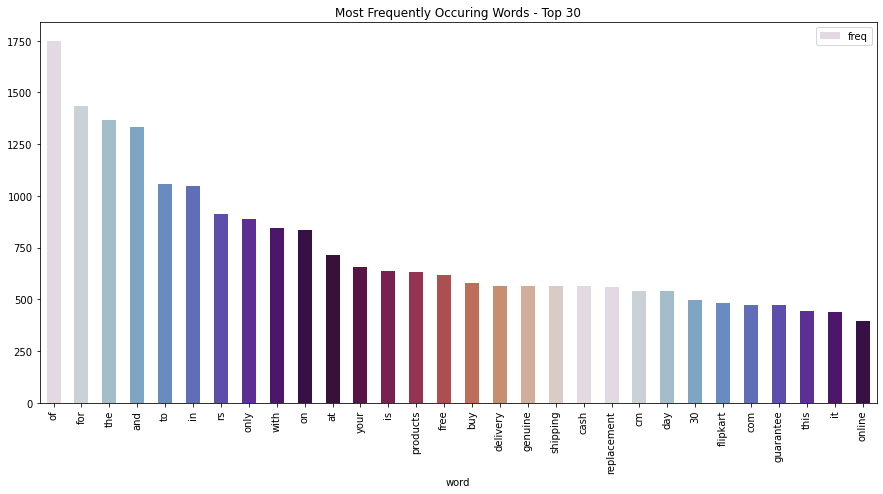

In [19]:
cv = CountVectorizer()
words = cv.fit_transform(tempo['description'])
sum_words = words.sum(axis=0)


words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

color = plt.cm.twilight(np.linspace(0, 1, 20))
frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = color)
plt.title("Most Frequently Occuring Words - Top 30")

Ici on confirme le wordcloud en ayant les mots les plus présents.

In [20]:
wordcloud.words_

{'of': 1.0,
 'for': 0.8201027984009137,
 'the': 0.7818389491719018,
 'and': 0.7607081667618504,
 'to': 0.6042261564820103,
 'in': 0.5979440319817247,
 'Rs': 0.5202741290691034,
 'Only': 0.508280982295831,
 'Product': 0.4934323243860651,
 'with': 0.4814391776127927,
 'On': 0.4768703597944032,
 'a': 0.4762992575671045,
 'at': 0.4077669902912621,
 'your': 0.3746430611079383,
 'is': 0.364363221016562,
 'Free': 0.35294117647058826,
 'Buy': 0.33181039406053686,
 'cm': 0.32438606510565393,
 'Delivery': 0.3238149628783552,
 'Genuine': 0.32210165619645914,
 'Shipping': 0.32210165619645914,
 'Cash': 0.32210165619645914,
 'Price': 0.32038834951456313,
 'Replacement': 0.31924614505996574,
 'Day': 0.3158195316961736,
 'it': 0.3089663049685894,
 'Flipkart': 0.2747001713306682,
 'com': 0.2701313535122787,
 'Guarantee': 0.26898914905768134,
 'mug': 0.2609937178754997,
 'this': 0.2535693889206168,
 'Feature': 0.23072529982866932,
 'online': 0.22615648201027985,
 'from': 0.21816105082809822,
 'Specifica

Text(0.5, 1.0, 'Least Frequently Occuring Words - Top 20')

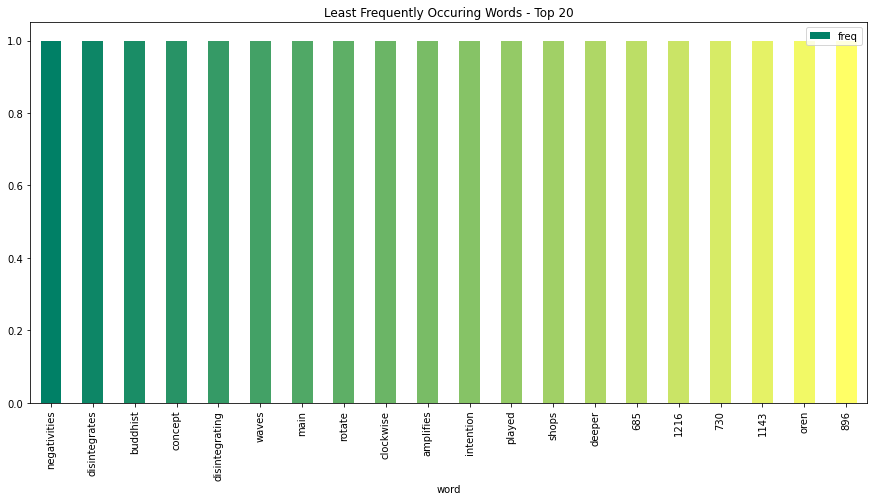

In [21]:
cv = CountVectorizer()
words = cv.fit_transform(tempo['description'])
sum_words = words.sum(axis=0)


words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

color = plt.cm.summer(np.linspace(0, 1, 20))
frequency.tail(20).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = color)
plt.title("Least Frequently Occuring Words - Top 20")

Ici on a les 20 mots les moins présents, on remarque beaucoup de nombres.

/home/mathieu/anaconda3/envs/myenv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


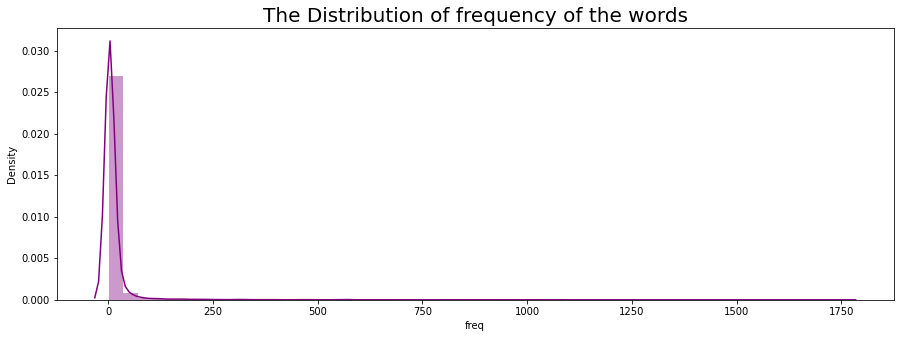

In [22]:
# looking at the distribution of frequency of the different words

plt.rcParams['figure.figsize'] = (15, 5)
sns.distplot(frequency['freq'], color = 'purple')
plt.title('The Distribution of frequency of the words', fontsize = 20)
plt.show()

In [23]:
frequency.shape

(6053, 2)

On aurait dans les 6053 mots différents.

### Processing netoyage texte

In [24]:
black_list = ['rs', 'cm', 'com', 'ml', 'id']

cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(tempo['description'])
sum_words = words.sum(axis=0)


words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

sw = set()
sw.update(black_list)
sw.update(frequency.loc[frequency['freq'] > 330, 'word'])
sw.update(tuple(nltk.corpus.stopwords.words('english')))


REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = sw


def clean_text(text):
    lemmatizer = WordNetLemmatizer()
    ps = PorterStemmer()
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = REPLACE_BY_SPACE_RE.sub('', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    #text = text.replace('x', '')
    text = re.sub(r'\W+', ' ', text)
    
    text = ' '.join(ps.stem(lemmatizer.lemmatize(word)) for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

tempo['description'] = tempo['description'].apply(clean_text)
tempo['description'] = tempo['description'].str.replace('\d+', '')


<ipython-input-24-37de0ece74e6>:42: FutureWarning: The default value of regex will change from True to False in a future version.
  tempo['description'] = tempo['description'].str.replace('\d+', '')


On utilise la méthode “Term Frequency — Inverse Document Frequency” pour créer nos features à partir du texte.

In [25]:
# vectorizing the data using Tfidf Vectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features = 100)
X = vectorizer.fit_transform(tempo['description'])

# getting the shape of X
print("Shape of X :", X.shape)


Shape of X : (1050, 100)


## TSNE

/home/mathieu/anaconda3/envs/myenv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

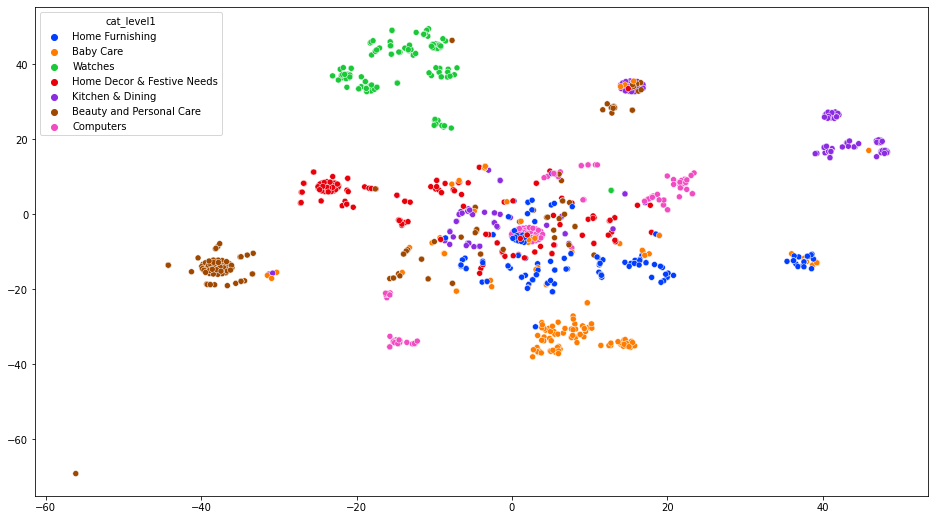

In [26]:
y = tempo.cat_level1
tsne = TSNE()
X_embedded = tsne.fit_transform(X)
fig, ax = plt.subplots(figsize=(16,9)) 
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette='bright')

On voit que le TSNE arrive facilement à séparé certains de nos clusters, ce qui démontrent l'efficacité de la méthode TF-IDF.

In [27]:
print_plot(10)

calibro sw analog digit watch men boy calibro present mtg black dial round watch fashion watch mtg add style statement brand known usag qualiti materi make appeal watch understand need youth well abl present wide rang watch custom varieti design style youth approach well execut brand get one see brilliantli lead brand style finish everyth els matter calibro present mtg black dial round watch fashion watch mtg add style statement brand known usag qualiti materi make appeal watch understand need youth well abl present wide rang watch custom varieti design style youth approach well execut brand get one see brilliantli lead brand style finish everyth els matter
Product: Watches


In [28]:
print_plot(110)

key twisha print kurti salwar kurta fabric cotton twisha print kurti salwar flamingo polka print kurta salwar black twisha print kurti salwar salwar kurta dupatta detail sleev sleeveless kurta type straight type kurti salwar neck round salwar fabric cotton kurta fabric cotton gener detail pattern print occas festiv ideal babi girl fabric care hand wash
Product: Baby Care


On voit ici que les textes ont bien été standardisés.

## KMEANS

In [29]:
true_k = 7
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=500, n_init=1)
model.fit(X)

KMeans(max_iter=500, n_clusters=7, n_init=1)

In [30]:
print("Top terms per cluster:")

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 babi
 type
 pack
 girl
 box
 color
 cotton
 gener
 number
 fabric
Cluster 1:
 price
 best
 usb
 laptop
 singl
 towel
 multicolor
 batteri
 home
 comfort
Cluster 2:
 sticker
 wall
 design
 water
 best
 price
 bring
 come
 decor
 style
Cluster 3:
 combo
 set
 care
 best
 gift
 price
 black
 blue
 ye
 pack
Cluster 4:
 watch
 analog
 men
 discount
 india
 great
 woman
 dial
 strap
 boy
Cluster 5:
 showpiec
 best
 price
 gift
 india
 decor
 set
 craft
 color
 beauti
Cluster 6:
 mug
 ceram
 coffe
 perfect
 gift
 love
 design
 safe
 make
 materi


In [31]:
tempo['kmeans'] = model.predict(X)

In [32]:
encode_trad = raw_data.loc[:,['cat_level1','cat_level1_encode']].groupby('cat_level1').first()

On affiche une matrice de confusion pour apprécier l'efficacité du Kmeans à classifier nos textes.

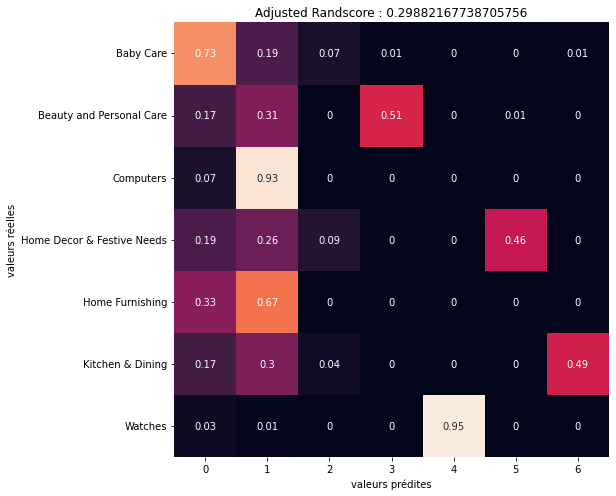

In [33]:
conf = np.round(confusion_matrix(raw_data['cat_level1_encode'], tempo['kmeans'], normalize='true'), 2)

plt.subplots(figsize=(16,8))
sns.heatmap(conf, square=True, annot=True, cbar=False
            , xticklabels=list(np.arange(0,7))
            , yticklabels=list(encode_trad.index), fmt='g')
plt.title("Adjusted Randscore : " + str(adjusted_rand_score(raw_data['cat_level1_encode'], tempo['kmeans'])))
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles');

Pour le Kmeans l'efficacité est faible avec un ARI d'à peine 30%, il arrive dans l'ensemble à classifier toutes les classes, mais avec peu d'efficacité pour 2 d'entre elles.

## Méthode LDA

On tente une cross-validation pour l'approche LDA.

In [34]:
random_grid = {'learning_decay': np.arange(0.4, 0.8, 0.1),
               'max_iter':np.round(np.linspace(10,200,4),0).astype(int),
              'learning_method': ['batch', 'online']}

In [35]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
lda = LDA(n_components=7)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
lda_random = RandomizedSearchCV(estimator = lda, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
lda_random.fit(X)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


/home/mathieu/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 32 is smaller than n_iter=100. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=LatentDirichletAllocation(n_components=7),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_decay': array([0.4, 0.5, 0.6, 0.7]),
                                        'learning_method': ['batch', 'online'],
                                        'max_iter': array([ 10,  73, 137, 200])},
                   random_state=42, verbose=2)

In [36]:
lda_random.best_params_

{'max_iter': 73, 'learning_method': 'online', 'learning_decay': 0.6}

Malgré l'optimisation par la cross-validation après test sur l'ARI, les résultats ne sont pas les mieux optimisés, car le métrique cible n'est pas l'ARI. 

In [37]:
#lda = LDA(n_components=7, learning_decay= 0.1, max_iter= 1000)
#lda.fit(X)

Après quelques tests, on arrive avec les hyper-paramètres suivants.

In [38]:
lda = LDA(n_components=7, learning_decay= 7, max_iter= 100)
lda.fit(X)

LatentDirichletAllocation(learning_decay=7, max_iter=100, n_components=7)

In [39]:
X_lda = lda.transform(X)

In [40]:
cluster_lda = []

for i in X_lda.argsort():
    cluster_lda.append(i[-1])

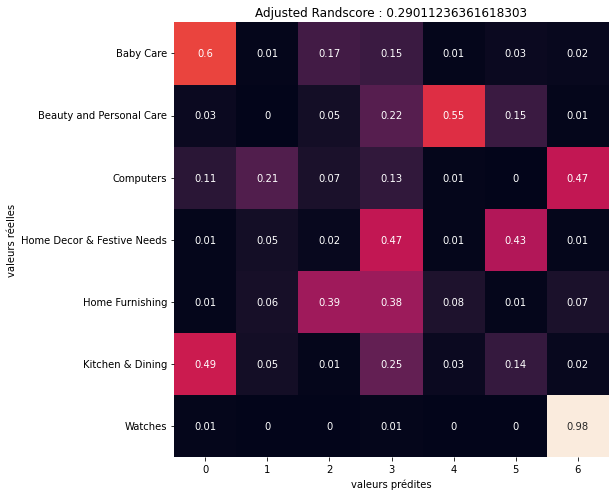

In [41]:
#corresp = [0, 6, 3, 1, 2, 4, 5]
#cluster_ajuste = conf_mat_transform(raw_data['cat_level1_encode'], pd.Series(cluster_lda), corresp)

conf = np.round(confusion_matrix(raw_data['cat_level1_encode'], pd.Series(cluster_lda), normalize='true'), 2)

plt.subplots(figsize=(16,8))
sns.heatmap(conf, square=True, annot=True, cbar=False
            , xticklabels=list(np.arange(0,7))
            , yticklabels=list(encode_trad.index), fmt='g')
plt.title("Adjusted Randscore : " + str(adjusted_rand_score(raw_data['cat_level1_encode'], pd.Series(cluster_lda))))
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles');

L'approche LDA est bien meilleur, même si les scores restent faibles, l'algorythme a une meilleur capacité à classifier, une classe est même clairement identifiée : "Watches".

## La méthode NMF

Pas de cross-validation dispobibles, différents test on permis d'optimiser les hyper-paramètres.

In [42]:
nmf = NMF(n_components=true_k, l1_ratio= 0.1, max_iter=500, solver='mu', beta_loss='kullback-leibler')
nmf.fit(X)

/home/mathieu/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


NMF(beta_loss='kullback-leibler', l1_ratio=0.1, max_iter=500, n_components=7,
    solver='mu')

In [43]:
X1 = nmf.transform(X)

In [44]:
tempo['cluster_nmf'] = cluster(X1) 

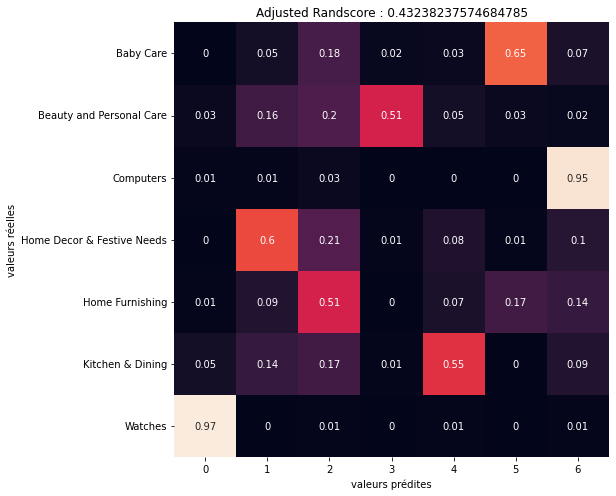

In [45]:
conf = np.round(confusion_matrix(raw_data['cat_level1_encode'], tempo['cluster_nmf'], normalize='true'), 2)

plt.subplots(figsize=(16,8))
sns.heatmap(conf, square=True, annot=True, cbar=False
            , xticklabels=list(np.arange(0,7))
            , yticklabels=list(encode_trad.index), fmt='g')
plt.title("Adjusted Randscore : " + str(adjusted_rand_score(raw_data['cat_level1_encode'], tempo['cluster_nmf'])))
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles');

La méthode NMF est clairement la meilleur avec un ARI à 43% et arrive à clairement identifié une deuxième classe : "computer".

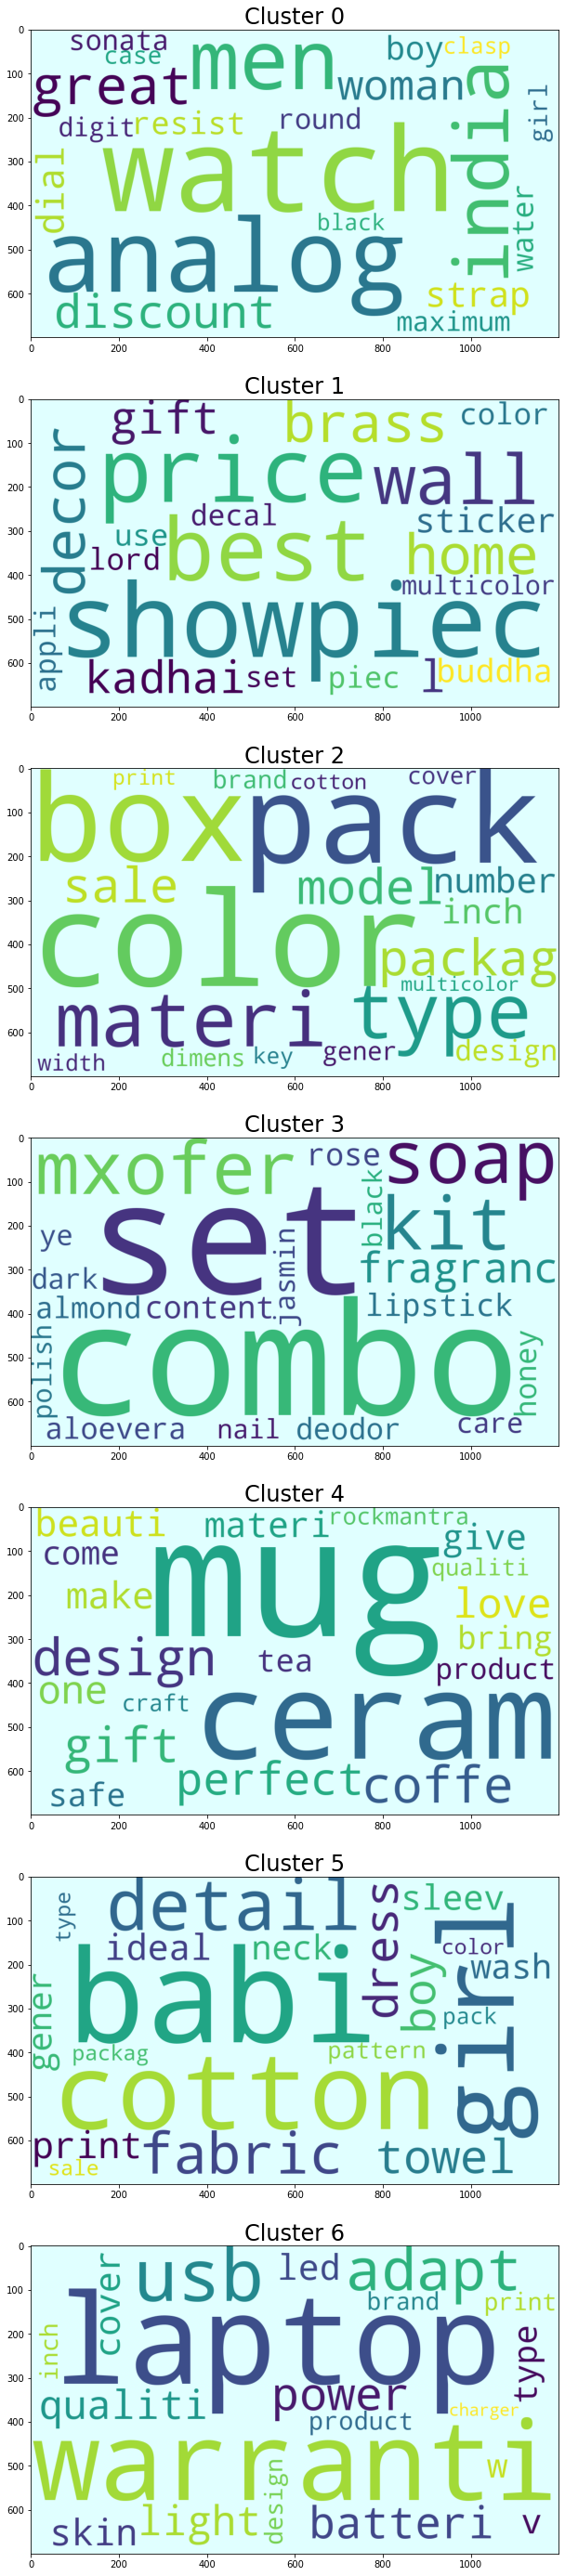

In [46]:
f, axs = plt.subplots(7,1, figsize = (24,50))
i=0

for ix in np.ndindex(axs.shape):
    if i == 7:
        break
    else:
        wordcloud = WordCloud(background_color = 'lightcyan',
                      width = 1200,
                      height = 700, collocations=False, stopwords='ignore', max_words=20).generate(' '.join(tempo.loc[tempo['cluster_nmf']==i,'description'].values))
        
        axs[ix].set_title("Cluster " + str(i), fontsize = 24)
        i+=1
        
        axs[ix].imshow(wordcloud)


On peut voir dans les wordclouds, que les mots les plus importants ont été identifiés dans l'ensemble et correspondent bien à la classes dont ils sont issus.

/home/mathieu/anaconda3/envs/myenv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

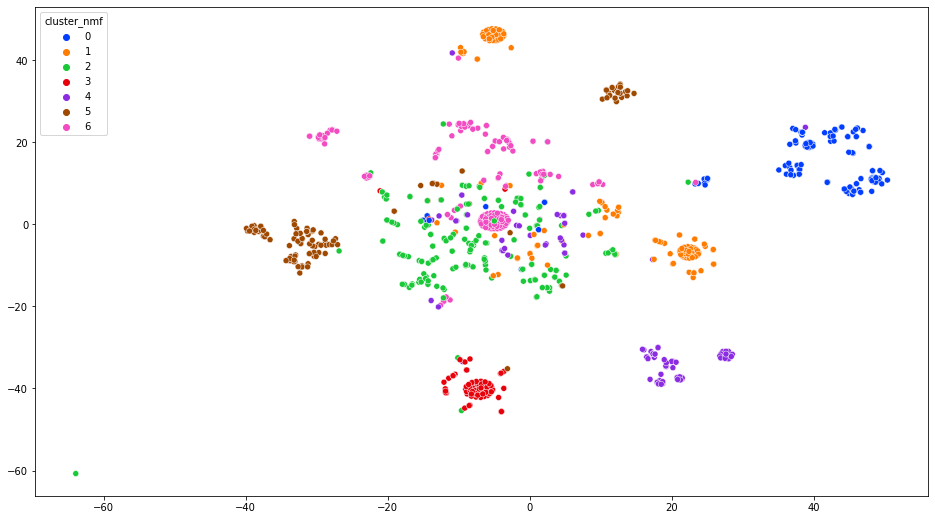

In [108]:
y = tempo['cluster_nmf']
tsne = TSNE()
X_embedded = tsne.fit_transform(X)
fig, ax = plt.subplots(figsize=(16,9)) 
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette='bright')

In [47]:
#def conf_mat_transform(y_true, corresp) :
#    '''Fonction qui transform la matrice de confusion en faisant correspondre les numéros de cluster'''  
#    corresp = corresp
#    print("Correspondance des clusters : ", corresp) 
#    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred) 
#    labels = pd.Series(y_true, name="y_true").to_frame() 
#    labels['y_pred_transform'] = labels['y_true'].apply(lambda x : corresp[x]) 
#    return labels['y_pred_transform'] 



## PARTIE IMAGE

In [48]:
import cv2
import keras
from keras import layers
from keras import backend as K
from keras.datasets import mnist
from keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D,Flatten
from keras import Input, Model
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.resnet_v2 import ResNet50V2
from PIL import Image

import plotly.graph_objects as go
import plotly.express as px

from scipy.io import loadmat

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             confusion_matrix, classification_report)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tqdm import tqdm
from numpy.random import seed
from time import time

In [54]:
def import_img(url, gray=False, transfer = None):
    size = 224, 224
    if transfer == "vgg16":
        size = 224, 224
    elif transfer == "xception":
        size = 299, 299
    elif transfer == "resnet":
        size = 224, 224

    transfer = str.lower(transfer)
    # read an image
    if gray == True:
        img = Image.open(url).convert('L')
    else:
        img = Image.open(url)
    img = img.resize(size) 
    
    # convert image object into array
    imageToMatrice = np.asarray(img).astype('float32')
    if transfer == "vgg16":
        imageToMatrice = keras.applications.vgg16.preprocess_input(imageToMatrice)
    elif transfer == "xception":
        imageToMatrice = keras.applications.xception.preprocess_input(imageToMatrice)
    elif transfer == "resnet":
        imageToMatrice = keras.applications.resnet_v2.preprocess_input(imageToMatrice)

    return imageToMatrice

def import_orb(url):
    dim = (224, 224)
    image = cv2.imread(url)
    
    R, G, B = cv2.split(image)

    output1_R = cv2.equalizeHist(R)
    output1_G = cv2.equalizeHist(G)
    output1_B = cv2.equalizeHist(B)

    image = cv2.merge((output1_R, output1_G, output1_B))
    image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    orb_detector = cv2.ORB_create(1000)
    keypoint, image = orb_detector.detectAndCompute(image, None)
    image = np.resize(image, (500 ,32))
    #image = np.nan_to_num(image)
    return image

## ORB

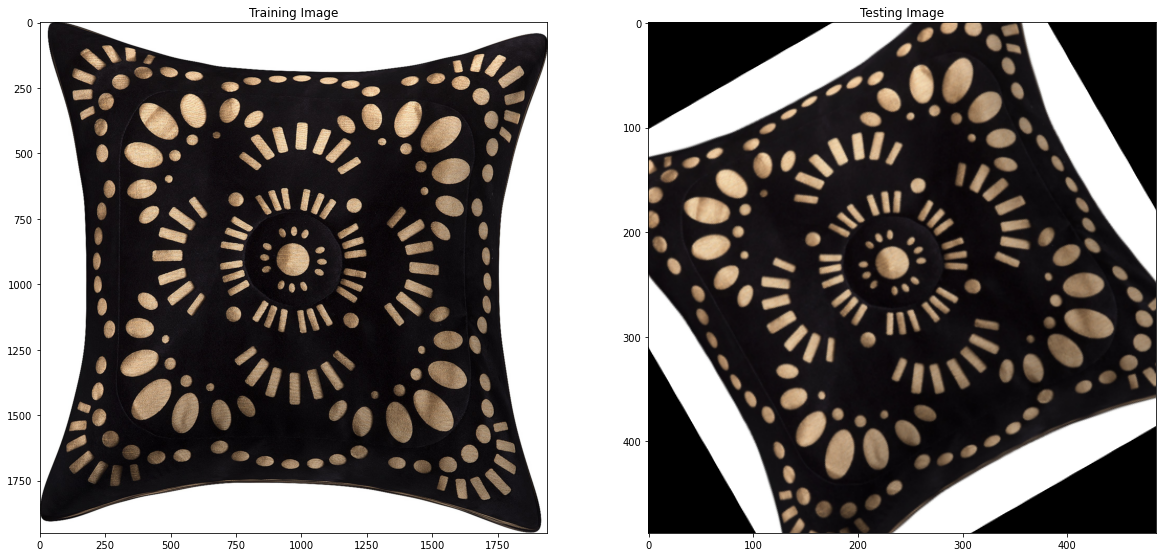

In [50]:
# Load the image
image1 = cv2.imread('Data/Images/2eb07dc77e2fc7e3668fd7ed9b864039.jpg')

# Convert the training image to RGB
training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# Convert the training image to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_RGB2GRAY)

# Create test image by adding Scale Invariance and Rotational Invariance
test_image = cv2.pyrDown(training_image)
test_image = cv2.pyrDown(test_image)
num_rows, num_cols = test_image.shape[:2]

rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 30, 1)
test_image = cv2.warpAffine(test_image, rotation_matrix, (num_cols, num_rows))

test_gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

# Display traning image and testing image
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Training Image")
plots[0].imshow(training_image)

plots[1].set_title("Testing Image")
plots[1].imshow(test_image)

Number of Keypoints Detected In The Training Image:  500
Number of Keypoints Detected In The Query Image:  500


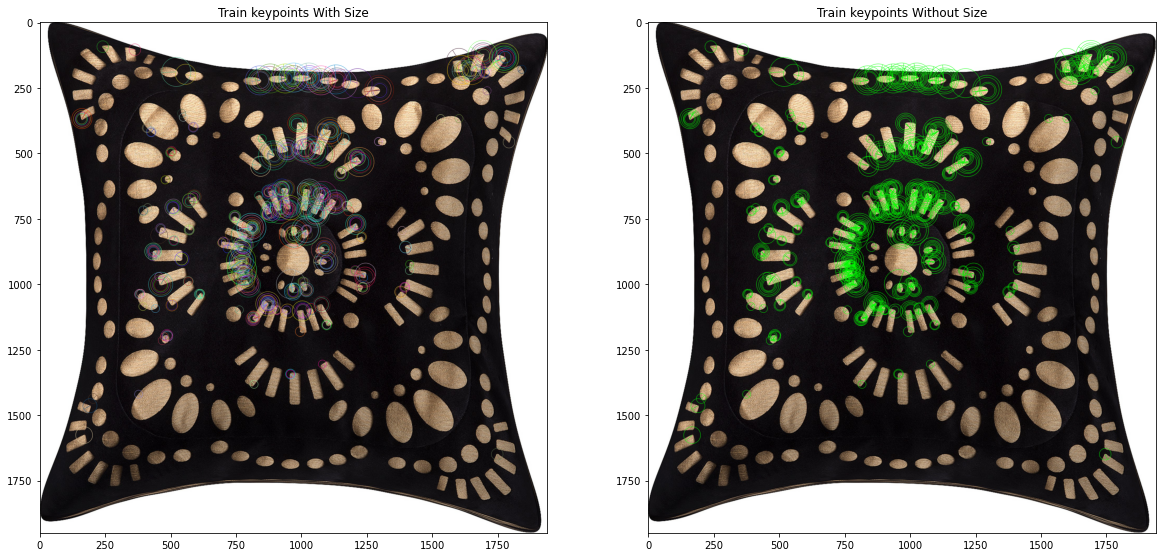

In [51]:
orb = cv2.ORB_create()

train_keypoints, train_descriptor = orb.detectAndCompute(training_gray, None)
test_keypoints, test_descriptor = orb.detectAndCompute(test_gray, None)

keypoints_without_size = np.copy(training_image)
keypoints_with_size = np.copy(training_image)

cv2.drawKeypoints(training_image, train_keypoints, keypoints_without_size, color = (0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv2.drawKeypoints(training_image, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without keypoints size
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size, cmap='gray')

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(test_keypoints))

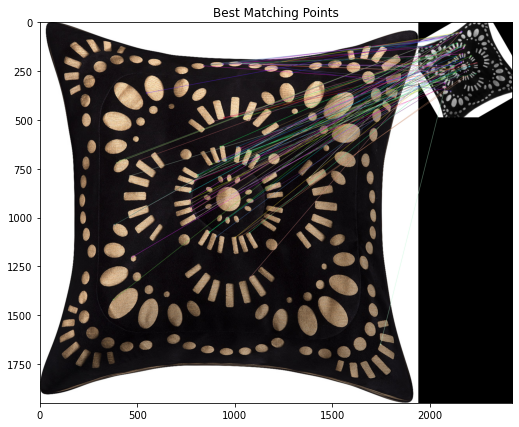


Number of Matching Keypoints Between The Training and Query :94


In [52]:
# Create a Brute Force Matcher object.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# Perform the matching between the ORB descriptors of the training image and the test image
matches = bf.match(train_descriptor, test_descriptor)

# The matches with shorter distance are the ones we want.
matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(training_image, train_keypoints, test_gray, test_keypoints, matches, test_gray, flags = 2)

# Display the best matching points
plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query :" + str(len(matches)))

In [55]:
temp_img = raw_data.loc[:, ['uniq_id','cat_level1']]


temp_img['img'] = temp_img['uniq_id'].apply(lambda x: import_orb('Data/Images/' + x + '.jpg'))

In [56]:
X_scaled = np.asarray(temp_img['img'].values.tolist(), dtype='float32')

In [58]:
X_scaled.shape

(1050, 500, 32)

In [59]:
features = X_scaled.flatten().reshape(1050, 16000)

In [60]:
features = np.nan_to_num(features)

In [61]:
nmf = NMF(n_components=7, l1_ratio= 0.1, max_iter=500, solver='mu', beta_loss='kullback-leibler')
nmf.fit(features)

/home/mathieu/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


NMF(beta_loss='kullback-leibler', l1_ratio=0.1, max_iter=500, n_components=7,
    solver='mu')

In [62]:
X1 = nmf.transform(features)

In [63]:
temp_img['ORB'] = cluster(X1) 

In [64]:
temp_img['ORB'] = cluster(features) 

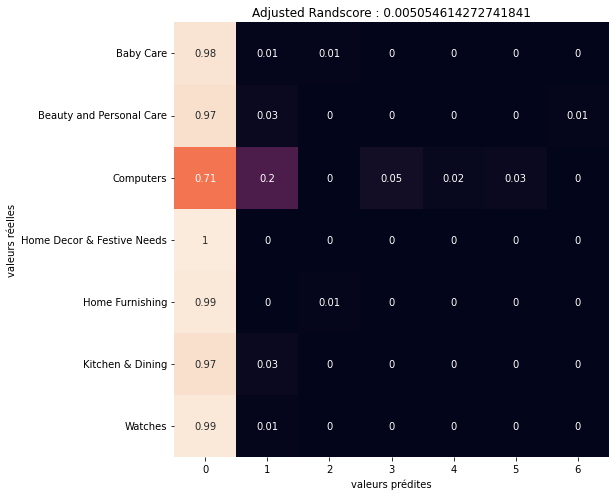

In [65]:
conf = np.round(confusion_matrix(raw_data['cat_level1_encode'], temp_img['ORB'], normalize='true'), 2)

plt.subplots(figsize=(16,8))
sns.heatmap(conf, square=True, annot=True, cbar=False
            , xticklabels=list(np.arange(0,7))
            , yticklabels=list(encode_trad.index), fmt='g')
plt.title("Adjusted Randscore : " + str(adjusted_rand_score(raw_data['cat_level1_encode'], temp_img['ORB'])))
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles');

/home/mathieu/anaconda3/envs/myenv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

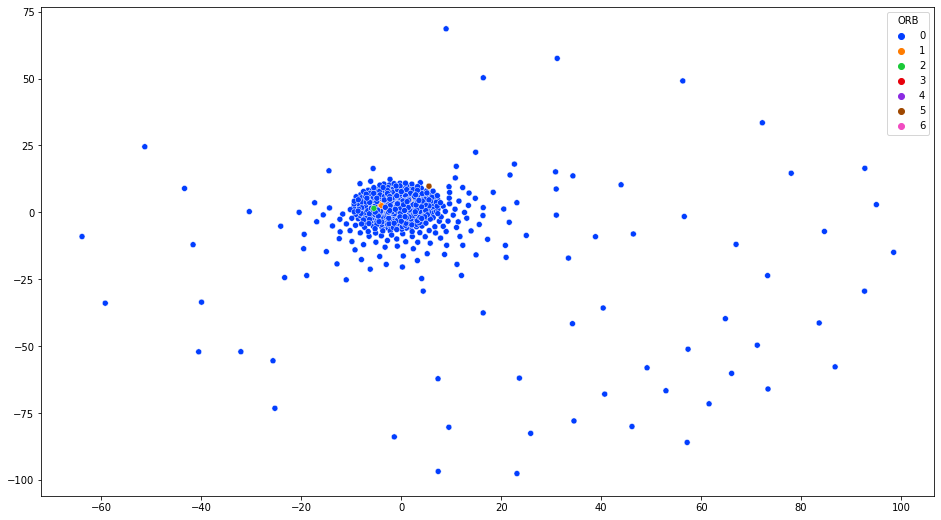

In [66]:
y = temp_img.ORB
tsne = TSNE()
X_embedded = tsne.fit_transform(features)
fig, ax = plt.subplots(figsize=(16,9)) 
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette='bright')

In [67]:
del features

## Transfer Learning

### VGG16

In [68]:
temp_img = raw_data.loc[:, ['uniq_id','cat_level1']]


temp_img['img'] = temp_img['uniq_id'].apply(lambda x: import_img('Data/Images/' + x + '.jpg', False, "vgg16"))

/home/mathieu/anaconda3/envs/myenv/lib/python3.9/site-packages/PIL/Image.py:2911: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [69]:
X_scaled = np.asarray(temp_img['img'].values.tolist())

In [70]:
# load model
model_info = VGG16()
# remove the output layer
model_info = Model(inputs=model_info.inputs, outputs=model_info.layers[-2].output)

In [71]:
model_info.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [72]:
features = X_vgg = model_info.predict(X_scaled)
print(features.shape)

(1050, 4096)


In [73]:
nmf = NMF(n_components=7, l1_ratio= 0.1, max_iter=500, solver='mu', beta_loss='kullback-leibler')
nmf.fit(features)

/home/mathieu/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


NMF(beta_loss='kullback-leibler', l1_ratio=0.1, max_iter=500, n_components=7,
    solver='mu')

In [74]:
X1 = nmf.transform(features)

In [75]:
temp_img['vgg16'] = cluster(X1) 

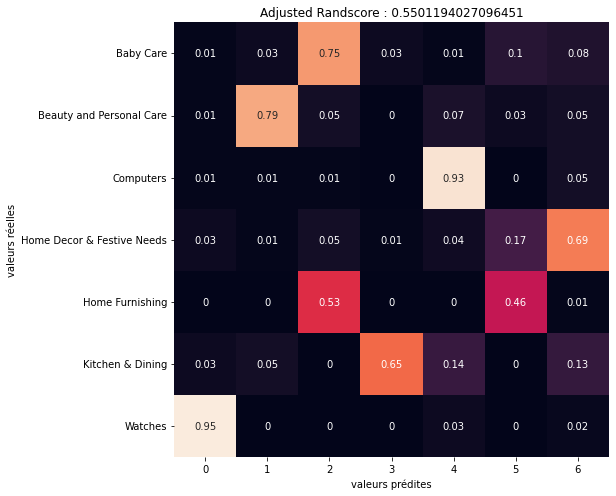

In [76]:
conf = np.round(confusion_matrix(raw_data['cat_level1_encode'], temp_img['vgg16'], normalize='true'), 2)

plt.subplots(figsize=(16,8))
sns.heatmap(conf, square=True, annot=True, cbar=False
            , xticklabels=list(np.arange(0,7))
            , yticklabels=list(encode_trad.index), fmt='g')
plt.title("Adjusted Randscore : " + str(adjusted_rand_score(raw_data['cat_level1_encode'], temp_img['vgg16'])))
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles');

/home/mathieu/anaconda3/envs/myenv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

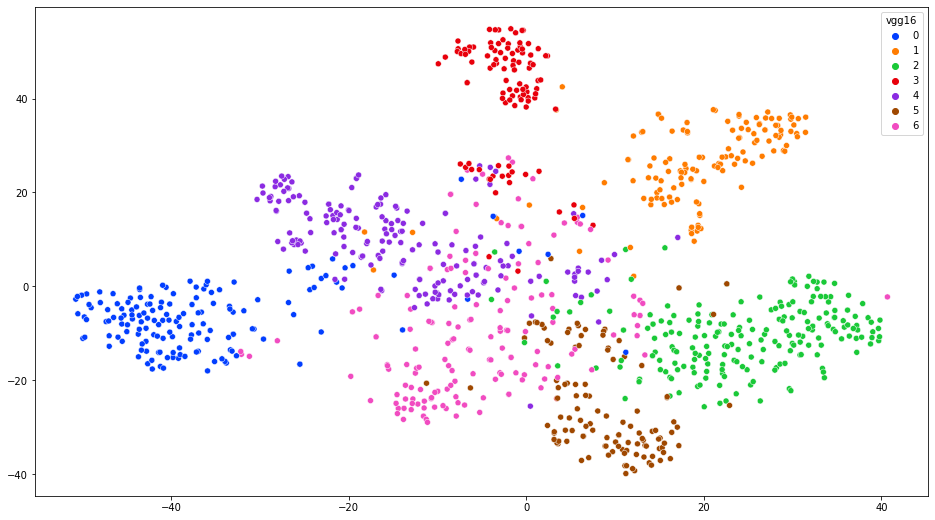

In [77]:
y = temp_img.vgg16
tsne = TSNE()
X_embedded = tsne.fit_transform(features)
fig, ax = plt.subplots(figsize=(16,9)) 
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette='bright')

In [78]:
del model_info
del features

## Xception

In [79]:
temp_img['img'] = temp_img['uniq_id'].apply(lambda x: import_img('Data/Images/' + x + '.jpg', False, "xception"))

/home/mathieu/anaconda3/envs/myenv/lib/python3.9/site-packages/PIL/Image.py:2911: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [80]:
X_scaled = np.asarray(temp_img['img'].values.tolist())

In [81]:
# load model
model_info = Xception()
# remove the output layer
model_info = Model(inputs=model_info.inputs, outputs=model_info.layers[-2].output)

In [82]:
model_info.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [83]:
features = model_info.predict(X_scaled)
print(features.shape)

(1050, 2048)


In [84]:
nmf = NMF(n_components=7, l1_ratio= 0.1, max_iter=500, solver='mu', beta_loss='kullback-leibler')
nmf.fit(features)

/home/mathieu/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


NMF(beta_loss='kullback-leibler', l1_ratio=0.1, max_iter=500, n_components=7,
    solver='mu')

In [85]:
X1 = nmf.transform(features)

In [86]:
temp_img['xception'] = cluster(X1) 

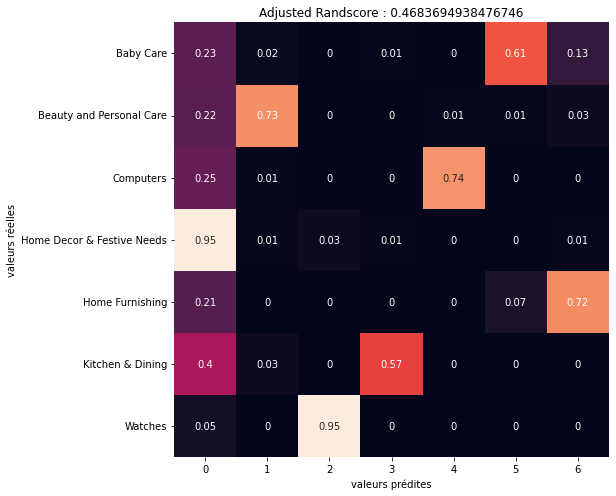

In [87]:
conf = np.round(confusion_matrix(raw_data['cat_level1_encode'], temp_img['xception'], normalize='true'), 2)

plt.subplots(figsize=(16,8))
sns.heatmap(conf, square=True, annot=True, cbar=False
            , xticklabels=list(np.arange(0,7))
            , yticklabels=list(encode_trad.index), fmt='g')
plt.title("Adjusted Randscore : " + str(adjusted_rand_score(raw_data['cat_level1_encode'], temp_img['xception'])))
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles');

/home/mathieu/anaconda3/envs/myenv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

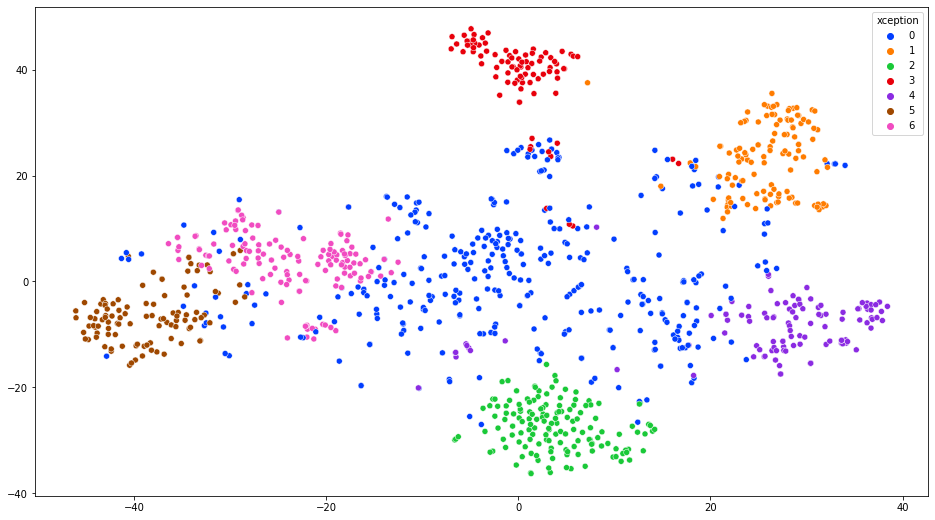

In [88]:
y = temp_img.xception
tsne = TSNE()
X_embedded = tsne.fit_transform(features)
fig, ax = plt.subplots(figsize=(16,9)) 
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette='bright')

In [89]:
del model_info
del features

## RESNET

In [90]:
temp_img['img'] = temp_img['uniq_id'].apply(lambda x: import_img('Data/Images/' + x + '.jpg', False, "resnet"))

/home/mathieu/anaconda3/envs/myenv/lib/python3.9/site-packages/PIL/Image.py:2911: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [91]:
X_scaled = np.asarray(temp_img['img'].values.tolist())

In [92]:
# load model
model_info = ResNet50V2()
# remove the output layer
model_info = Model(inputs=model_info.inputs, outputs=model_info.layers[-2].output)

In [93]:
model_info.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [94]:
features = model_info.predict(X_scaled)
print(features.shape)

(1050, 2048)


In [95]:
nmf = NMF(n_components=7, l1_ratio= 0.1, max_iter=500, solver='mu', beta_loss='kullback-leibler')
nmf.fit(features)

/home/mathieu/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


NMF(beta_loss='kullback-leibler', l1_ratio=0.1, max_iter=500, n_components=7,
    solver='mu')

In [96]:
X1 = nmf.transform(features)

In [97]:
temp_img['resnet'] = cluster(X1) 

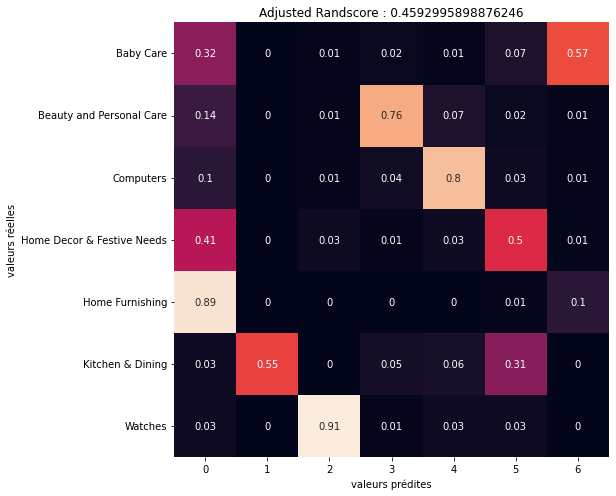

In [98]:
conf = np.round(confusion_matrix(raw_data['cat_level1_encode'], temp_img['resnet'], normalize='true'), 2)

plt.subplots(figsize=(16,8))
sns.heatmap(conf, square=True, annot=True, cbar=False
            , xticklabels=list(np.arange(0,7))
            , yticklabels=list(encode_trad.index), fmt='g')
plt.title("Adjusted Randscore : " + str(adjusted_rand_score(raw_data['cat_level1_encode'], temp_img['resnet'])))
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles');equ

/home/mathieu/anaconda3/envs/myenv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

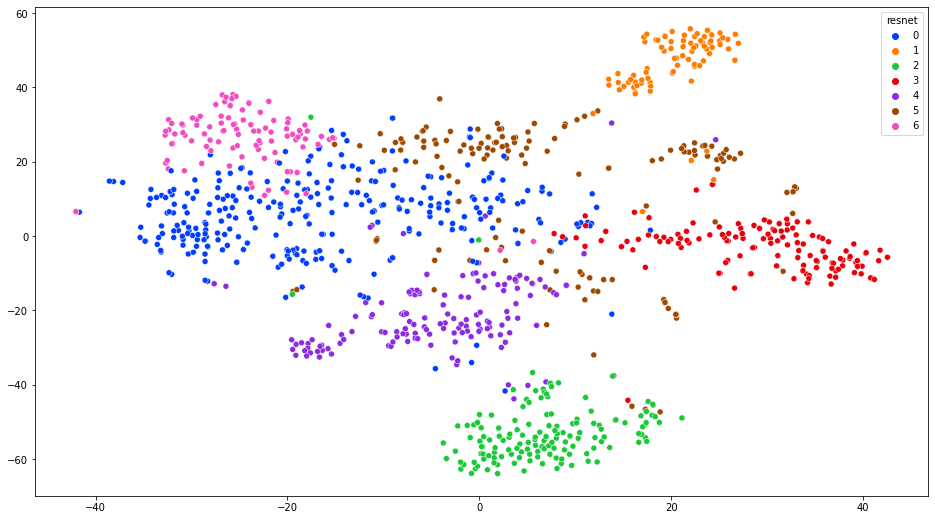

In [99]:
y = temp_img.resnet
tsne = TSNE()
X_embedded = tsne.fit_transform(features)
fig, ax = plt.subplots(figsize=(16,9)) 
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette='bright')

In [100]:
del model_info
del features

## FUSION TEXTES + IMAGES

In [101]:
X = X.toarray()
X_mix = np.concatenate((X, X_vgg), axis =1)

In [102]:
X_mix.shape

(1050, 4196)

In [103]:
nmf = NMF(n_components=7, l1_ratio= 0.1, max_iter=500, solver='mu', beta_loss='kullback-leibler')
nmf.fit(X_mix)

/home/mathieu/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


NMF(beta_loss='kullback-leibler', l1_ratio=0.1, max_iter=500, n_components=7,
    solver='mu')

In [104]:
X1 = nmf.transform(X_mix)

In [105]:
X1_cluster = cluster(X1) 

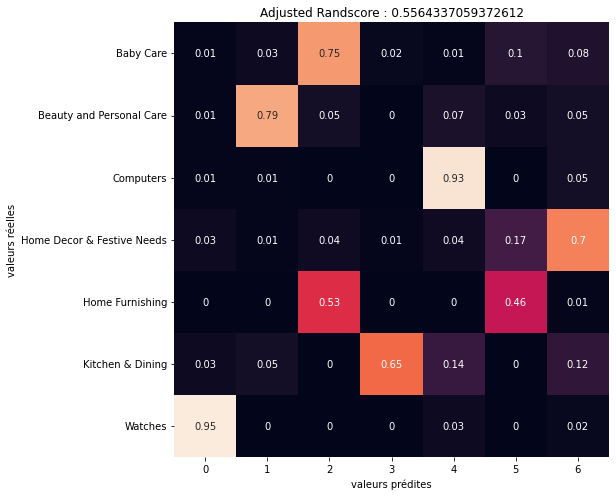

In [106]:
conf = np.round(confusion_matrix(raw_data['cat_level1_encode'], X1_cluster, normalize='true'), 2)

plt.subplots(figsize=(16,8))
sns.heatmap(conf, square=True, annot=True, cbar=False
            , xticklabels=list(np.arange(0,7))
            , yticklabels=list(encode_trad.index), fmt='g')
plt.title("Adjusted Randscore : " + str(adjusted_rand_score(raw_data['cat_level1_encode'], X1_cluster)))
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles');

/home/mathieu/anaconda3/envs/myenv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

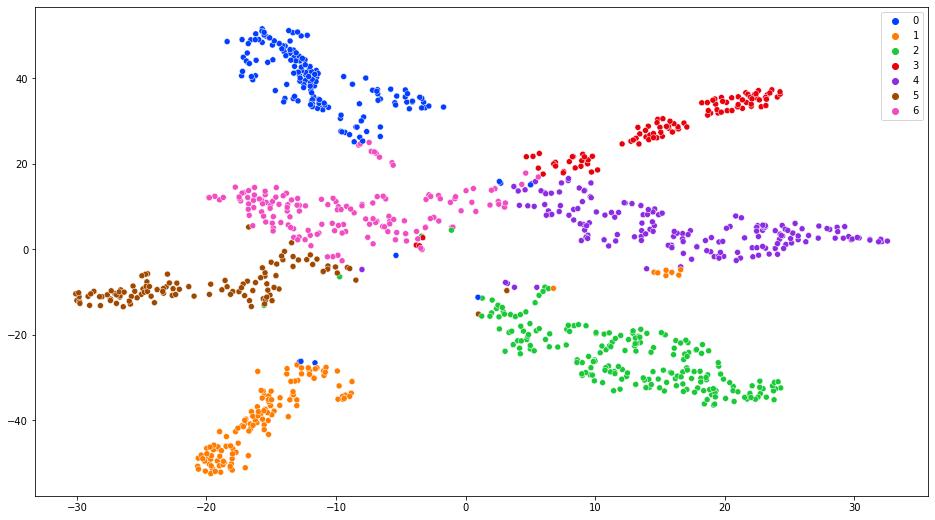

In [109]:
y = X1_cluster
tsne = TSNE()
X_embedded = tsne.fit_transform(X1)
fig, ax = plt.subplots(figsize=(16,9)) 
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette='bright')